In [1]:
# objective function
def objective(x):
	return 3 + 4*x + x**2.0
 
# derivative of objective function
def derivative(x):
	return 4 + x*2.0

>0 f([0.34724774]) = 4.50957
>1 f([-0.12220181]) = 2.52613
>2 f([-0.49776144]) = 1.25672
>3 f([-0.79820916]) = 0.44430
>4 f([-1.03856732]) = -0.07565
>5 f([-1.23085386]) = -0.40841
>6 f([-1.38468309]) = -0.62139
>7 f([-1.50774647]) = -0.75769
>8 f([-1.60619718]) = -0.84492
>9 f([-1.68495774]) = -0.90075


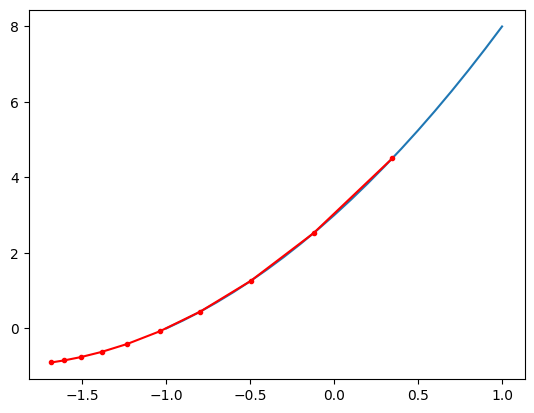

In [2]:
import numpy as np
from numpy import asarray
from numpy import arange
from numpy.random import rand
from numpy.random import seed
import matplotlib.pyplot as plt
# plain gradient descent with fixed learning rate using analytic expression of gradient
# adding momentum
# minibatch sgd, learning schedule
# adagrad with and without momentum, sgd and gd 
# rms prop and adam
# note that the minimum is at x=-2, the closer the solution to -2 the better
# define the total iterations
n_iter = 10



# 1 plain gradient descent without momentum
# gradient descent algorithm
def gradient_descent(objective, derivative, bounds, n_iter, step_size):
	# track all solutions
	solutions, scores = list(), list()
	# generate an initial point
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# run the gradient descent
	for i in range(n_iter):
		# calculate gradient
		gradient = derivative(solution)
		# take a step
		solution = solution - step_size * gradient
		# evaluate candidate point
		solution_eval = objective(solution)
		# store solution
		solutions.append(solution)
		scores.append(solution_eval)
		# report progress
		print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
	return [solutions, scores]
 
# seed the pseudo random number generator
seed(4)
# define range for input
bounds = asarray([[-1.0, 1.0]])
# define the step size
step_size = 0.1
# perform the gradient descent search
solutions, scores = gradient_descent(objective, derivative, bounds, n_iter, step_size)
# sample input range uniformly at 0.1 increments
inputs = arange(bounds[0,0], bounds[0,1]+0.1, 0.1)
# compute targets
results = objective(inputs)
# create a line plot of input vs result
plt.plot(inputs, results)
# plot the solutions found
plt.plot(solutions, scores, '.-', color='red')
# show the plot
plt.show()

>0 f([0.34724774]) = 4.50957
>1 f([-0.29824539]) = 1.89597
>2 f([-0.83224425]) = 0.36365
>3 f([-1.22599506]) = -0.40092
>4 f([-1.49892129]) = -0.74892
>5 f([-1.6810149]) = -0.89825
>6 f([-1.79944]) = -0.95978
>7 f([-1.87507953]) = -0.98439
>8 f([-1.92275549]) = -0.99403
>9 f([-1.95250717]) = -0.99774


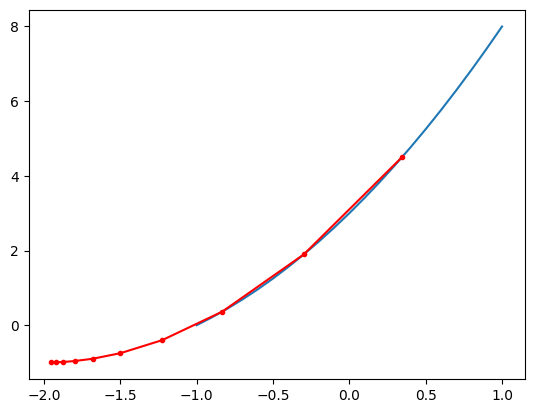

In [3]:
# 2 adding momentum

# gradient descent algorithm
def gradient_descent(objective, derivative, bounds, n_iter, step_size, momentum):
	# track all solutions
	solutions, scores = list(), list()
	# generate an initial point
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# keep track of the change
	change = 0.0
	# run the gradient descent
	for i in range(n_iter):
		# calculate gradient
		gradient = derivative(solution)
		# calculate update
		new_change = step_size * gradient + momentum * change
		# take a step
		solution = solution - new_change
		# save the change
		change = new_change
		# evaluate candidate point
		solution_eval = objective(solution)
		# store solution
		solutions.append(solution)
		scores.append(solution_eval)
		# report progress
		print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
	return [solutions, scores]
 
# seed the pseudo random number generator
seed(4)
# define range for input
bounds = asarray([[-1.0, 1.0]])
# define the step size
step_size = 0.1
# define momentum
momentum = 0.3
# perform the gradient descent search with momentum
solutions, scores = gradient_descent(objective, derivative, bounds, n_iter, step_size, momentum)
# sample input range uniformly at 0.1 increments
inputs = arange(bounds[0,0], bounds[0,1]+0.1, 0.1)
# compute targets
results = objective(inputs)
# create a line plot of input vs result
plt.plot(inputs, results)
# plot the solutions found
plt.plot(solutions, scores, '.-', color='red')
# show the plot
plt.show()

# comparison with and without momentum
# we note that with momentum we are quite close to -2 with a delta of 0.05 while without momentum the delta equals 0.32


In [4]:
# the objective
# we implement the MSE as cost function, thus we fit an OLS model
def MSE(y_data, X, beta):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = X @ beta
    return np.sum((y_data-y_model)**2)/n

# the derivative (wrt beta)
def grad_MSE(y_data, X, beta):
    y_model = X @ beta
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    return 2.0/n*X.T @ ((X @ beta)-y_data)

In [5]:
def create_X(x, y, n, intercept=True):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)

    if intercept:
        X = np.ones((N,l))

        for i in range(1,n+1):
            q = int((i)*(i+1)/2)
            for k in range(i+1):
                X[:,q+k] = (x**(i-k))*(y**k)

    else:
        X = np.ones((N,l-1))

        for i in range(1,n+1):
            q = int((i)*(i+1)/2) - 1
            for k in range(i+1):
                X[:,q+k] = (x**(i-k))*(y**k)

    return X

In [6]:
# gradient descent with and without momentum
import numpy as np


x = np.random.rand(100)
y = np.random.rand(100)
poldegree = 3
X = create_X(x, y, poldegree, intercept=True) # n denotes polynomial degree
n = X.shape[0]
H = (2.0/n)* X.T @ X
EigValues, EigVectors = np.linalg.eig(H)
eta = 1.0/np.max(EigValues)

def gd(X, Niterations = 100):
    gradients = 1
    theta = np.random.randn(2,1)
    for iter in range(Niterations):
        if np.linalg.norm(gradients) > 10**(-4):
            gradients = 2.0/n*X.T @ ((X @ theta)-y.reshape(-1, 1))
            theta -= eta*gradients
        else: break
    return theta

def gd_momentum(X, Niterations = 100, delta_momentum=0.03):
    gradients = 1
    change=0
    theta = np.random.randn(2,1)
    for iter in range(Niterations):
        if np.linalg.norm(gradients) > 10**(-4):
            gradients = 2.0/n*X.T @ ((X @ theta)-y.reshape(-1, 1))
            new_change = eta*gradients + delta_momentum * change
            theta-= new_change
            change = new_change
        else: break
    return theta


In [7]:
# 3 stochastic gradient descent with mini batches and given number of epochs
# implementing SGD to avoid the matrix inversion in OLS
# stopping of the algorithm by number of epochs determined 


# we implement the MSE as cost function, thus we fit an OLS model
def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = y_model.reshape(-1, 1)
    return np.sum((y_data-y_model)**2)/n

n = 100 #100 datapoints 
x = -4 + 8*np.random.rand(n) # we know the minimum is in this intervall
y = objective(x)

M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
n_epochs = 50 #number of epochs
t0, t1 = 5, 50

X = np.column_stack([x**0, x])
theta_linreg = np.linalg.inv(X.T @ X) @ X.T @ y # to compare to OLS
H = (2.0/n)* X.T @ X
EigValues, EigVectors = np.linalg.eig(H)

eta = 1.0/np.max(EigValues) # if Hessian matrix exist this is the best way

def learning_schedule(t): # sometimes also referred to as learning schedule, denotes the step length, converges to zero for large epochs
    return t0/(t+t1)

theta = -4 +8*np.random.randn(2,1)
for epoch in range(n_epochs):
# Can you figure out a better way of setting up the contributions to each batch?
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (2.0/M)* xi.T @ ((xi @ theta)-yi.reshape(-1, 1))
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta*gradients

print(f"SGD theta:{theta}")
print(f"OLS theta:{theta_linreg}")


SGD theta:[[8.12901241]
 [4.14173376]]
OLS theta:[8.13233768 4.01937059]
